# Identify fraud from Enron email

## Introduction

The Enron Corporation went bankrupt in 2011 and was one of the biggest audit failures in American history (Wikipedia, 2016a). On the aftermath of the bankruptcy a database of emails from employees of the Enron Corporation was acquired by the Federal Energy Regulatory Commission in order to investigate the company's collapse (Wikipedia, 2016b). At the end of the investigation the email database was put on the public domain to be used for historical research and academic purposes.

The Enron corpus is therefore the starting point of our investigation. We want to use our newly acquired knowledge of machine learning techniques to build a classifier which can identify people of interest in the Enron scandal.

A "Person Of Interest" is defined in the scope of this project as:

* someone who was indicted, or
* someone who settled without admitting guilt, or
* someone who testified in exchange for immunity.

The [poi_names.txt](poi_names.txt) file lists the names of people of interest identified through a [USAToday article](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm).

For many of the people identified through the news article, we do not actually have their email box. However, we can check if they were sending emails to the people whose inboxes we have, by scraping the email `from:` fields. Additionally, we have [financial information](enron61702insiderpay.pdf) available which lists salary, bonuses, stock ownership and other payments made to the enron employees. 

By combining the email and financial datasets we will try to build a supervised classification model which can identify Persons Of Interest.



## Dataset and Question
### Data Exploration

In [1]:
# importing what we need for the exploration
from __future__ import division, print_function
import sys
sys.path.append("../tools/")
import poi_id
import pprint

In [2]:
# Load dataset
enron_data = poi_id.load_dataset()

In [3]:
# Data structure
pprint.pprint(next(enron_data.iteritems()))

('METTS MARK',
 {'bonus': 600000,
  'deferral_payments': 'NaN',
  'deferred_income': 'NaN',
  'director_fees': 'NaN',
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': 'NaN',
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': 'NaN',
  'long_term_incentive': 'NaN',
  'other': 1740,
  'poi': False,
  'restricted_stock': 585062,
  'restricted_stock_deferred': 'NaN',
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062})


The dataset is already arranged in a python dictionary. The keys of the dictionary are the names of the people and the values are a dictionary with the variable values corresponding to that person.

#### Variable meaning

* `poi`: is this person a poi? Can be True or False.

##### Email dataset
* `to_messages`: number of messages sent do this person.
* `from_messages`: number of messages sent by this person.
* `from_this_person_to_poi`: number of messages sent from this person to a poi.
* `email_address`: email address of the person.
* `from_poi_to_this_person`: number of emails sent from a poi to this person.
* `shared_receipt_with_poi`: number of emails that this person got which were also sent to a poi.

##### Financial dataset

The units of these variables are US Dollars.

* `salary`: base salary.
* `deferral_payments`: deferred compensation due to termination of employment or due to in-service withdrawals as per plan provisions.
* `total_payments`: total payments (includes all kind of payments except stocks)
* `exercised_stock_options`: amounts from exercised stock option.
* `bonus`: annual cash incentives paid based upon company performance.
* `restricted_stock`: gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred.
* `restricted_stock_deferred`: value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.
* `total_stock_value`: total stock value.
* `expenses`: reimbursements of business expenses.
* `loan_advances`: total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment.
* `other`: items such as payments for severance, consulting services, relocation costs, tax advances and allowances for employees on international assignment.
* `director_fees`: cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.
* `deferred_income`: Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement.
* `long_term_incentive`: long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success.


In [4]:
# How many people?
len(enron_data)

146

In [5]:
# How many POIs in our dataset?
len([p for p in enron_data.itervalues() if p["poi"]])

18

In [6]:
# How many POIs in our POI list:
with open("poi_names.txt") as f:
    pois_total = len(f.readlines()[2:])
print(pois_total)

35


We have only 18 POIs in a total of 146 people in our dataset. This means that our classes are unbalanced. We should keep this in mind later on when selecting a classification algorithm. We have also identified additional POIs in our poi_names.txt file. However, there was no financial information about them, and many did not have emails. Including them in the dataset with missing features would create an artificial association between being a POI and having missing data.

Of course, we can argue that just 18 examples of POIs is very few to find a pattern in the class. But, that's what we got and we'll see what we can do with it.

In [7]:
# Missing values per feature:
from collections import defaultdict
missing_values = defaultdict(int)
features_list = next(enron_data.itervalues()).keys()
for person in enron_data.itervalues():
    for feature in features_list:
        if person[feature] == "NaN":
            missing_values[feature] += 1
missing_values = {k:round(v/len(enron_data),3) for k,v in missing_values.iteritems()}
pprint.pprint(missing_values)

{'bonus': 0.438,
 'deferral_payments': 0.733,
 'deferred_income': 0.664,
 'director_fees': 0.884,
 'email_address': 0.24,
 'exercised_stock_options': 0.301,
 'expenses': 0.349,
 'from_messages': 0.411,
 'from_poi_to_this_person': 0.411,
 'from_this_person_to_poi': 0.411,
 'loan_advances': 0.973,
 'long_term_incentive': 0.548,
 'other': 0.363,
 'restricted_stock': 0.247,
 'restricted_stock_deferred': 0.877,
 'salary': 0.349,
 'shared_receipt_with_poi': 0.411,
 'to_messages': 0.411,
 'total_payments': 0.144,
 'total_stock_value': 0.137}


We can see that some features have a big proportion of missing values. 

We can start already to do a bit of feature selection at this stage. Features with missing data > 0.5 will not be used for the classification models. This means the following features will not be used:

In [8]:
pprint.pprint([key for key, value in missing_values.iteritems() if value >= 0.5])

['deferral_payments',
 'restricted_stock_deferred',
 'deferred_income',
 'loan_advances',
 'director_fees',
 'long_term_incentive']


### Outlier Investigation

As investigated before in the mini projects, we know that one of the data points corresponds to a "TOTAL" row of the original source of data. We can remove this outlier before further investigation.

In [9]:
# Lets remove the outlier. It gets printed if still there
try:
    pprint.pprint(enron_data.pop("TOTAL"))
except KeyError:
    print("Outlier was already removed")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}


In order to investigate additional outliers, histograms and boxplots were created for all variables in the data.

As an example, we'll include the histogram and boxplot for the salary variable:

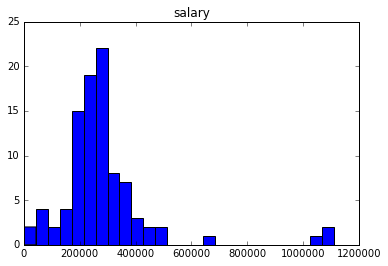

In [10]:
%matplotlib inline
import plotting
plotting.histogram(enron_data, "salary")

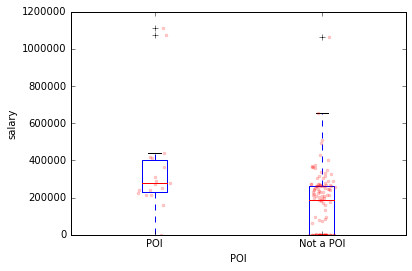

In [11]:
plotting.boxplot_poi(enron_data, "salary")

On the boxplot, the data points are overlaid on the boxes, to have a better understanding of the distribution.

The plots for the remaining variables are on the Plots notebook: [Plots Notebook](Plots.ipynb) or [Plots html](Plots.html).

The removal of outliers it's always a delicate topic. By observing the plots we can see that for most variables there is usually a skew distribution with some points at extreme values. We may be tempted to remove these values. However, on most cases they seem to correspond to real values and not a error in the data. The extreme values are usually corresponding to people with higher positions in the company which would have higher compensation.

We want our classification model to be able to identify people of interest no matter in which level of the hierarchy inside the company they were. Therefore, these extreme values which seem to be just people with higher than average compensation or higher than average email activity are left in the dataset.

When exploring the dataset for outliers, we found an observation with the name "THE TRAVEL AGENCY IN THE PARK", which does not correspond to an individual. This observation was therefore removed from the dataset.

In [12]:
# Lets remove the outlier. It gets printed if still there
try:
    pprint.pprint(enron_data.pop("THE TRAVEL AGENCY IN THE PARK"))
except KeyError:
    print("Outlier was already removed")

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}


## Optimize Feature Selection/Engineering

### Create new features

When looking at the available features one thing comes to my mind. Most features are absolute numbers. We have absolute number of from and to messages. And we have the absolute values of the salary and other kinds of compensations. When using the variables "from_this_person_to_poi" and "from_poi_to_this_person" it seems to be more useful to use the ratio of the variable with the total sent and received messages. A person who sends very few emails will naturally send also very few emails to a poi and _vice versa_.

Similarly, in the financial information, it may make more sense to use a ratio of, e.g. bonus by the salary. A person with a higher salary with a high bonus seems to be a normal ocurrence, but if the bonus are too high in regards to the salary, maybe there is something fishy going on.

The following new features will be created:

- `fraction_from_poi` = `from_poi_to_this_person` / `to_messages`
- `fraction_to_poi` = `from_this_person_to_poi` / `from_messages`
- `fraction_shared` = `shared_receipt_with_poi` / `to_messages`
- `ratio_payments_salary` = `total_payments` / `salary`
- `ratio_stocks_salary` = `total_stock_value` / `salary`

For the email data we have the fraction of emails exchanged, and shared receipts with POIS. For the financial data, the ratio of total payments and total stock value with the salary is calculated.

In [13]:
#Adding the new features to the dataset
new_features_funs_list = [poi_id.fraction_from_poi, poi_id.fraction_to_poi, poi_id.fraction_shared,
                              poi_id.ratio_payments_salary, poi_id.ratio_stocks_salary]
poi_id.add_new_features(enron_data, new_features_funs_list);

### Select features

When exploring missing values, we identified a few variables with high percentage of missing data. These will not be used in the models.

Additionally, using the `SelectKBest` we can get a rank of feature importance based on univariate anova f tests. We can then examine if the new engineered features (ratios) provide more discriminant power than the bare variables.

In [14]:
new_features_list = next(enron_data.itervalues()).keys()
vars_to_exclude = ['deferral_payments',
 'restricted_stock_deferred',
 'deferred_income',
 'loan_advances',
 'director_fees',
 'long_term_incentive',#too much missing values in them
 'email_address',
  'poi']

for var in vars_to_exclude:
    new_features_list.remove(var)


new_features_list = ["poi"]+new_features_list

from sklearn import feature_selection

selector = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k="all")
labels, features = poi_id.extract_features(enron_data, new_features_list)

    
selector.fit(features, labels)
pprint.pprint(sorted(zip(selector.scores_, new_features_list[1:]), reverse=True))

[(24.815079733218194, 'exercised_stock_options'),
 (24.182898678566879, 'total_stock_value'),
 (20.792252047181535, 'bonus'),
 (18.289684043404513, 'salary'),
 (16.409712548035799, 'fraction_to_poi'),
 (9.2128106219771002, 'restricted_stock'),
 (9.1012687391935145, 'fraction_shared'),
 (8.7727777300916792, 'total_payments'),
 (8.589420731682381, 'shared_receipt_with_poi'),
 (6.0941733106389453, 'expenses'),
 (5.2434497133749582, 'from_poi_to_this_person'),
 (4.1874775069953749, 'other'),
 (3.1280917481567374, 'fraction_from_poi'),
 (2.6874175908440314, 'ratio_payments_salary'),
 (2.3826121082276739, 'from_this_person_to_poi'),
 (1.6463411294420076, 'to_messages'),
 (0.16970094762175533, 'from_messages'),
 (0.02385275351322259, 'ratio_stocks_salary')]


The variables `fraction_to_poi` and `fraction_shared` have higher scores than the non fraction equivalents. We will keep these and remove the non-fractions. The fraction_from_poi has a worse score than the non ratio variables, therefore it will not be included. The variables `ratio_payments_salary` and `ratio_stocks_salary` appear on the bottom of our table. We will not be using them in our final analysis.

In [15]:
extra_exclude = ["from_this_person_to_poi",
                "shared_receipt_with_poi",
                "fraction_from_poi",
                "ratio_payments_salary",
                "ratio_stocks_salary"]

for var in extra_exclude:
    try:
        new_features_list.remove(var)
    except ValueError:
        print("Already excluded")
        
pprint.pprint(new_features_list)

['poi',
 'to_messages',
 'bonus',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_shared',
 'fraction_to_poi',
 'exercised_stock_options',
 'from_messages',
 'other']


Further feature selection will be performed on the model building section. We will use `SelectKBest` together with `GridSearchCV` to find the number of features that give the best performance.

### Properly scale features

For both the algorithms I will be using, it is not necessary to perform scaling on the features.

## Pick and Tune an Algorithm

### Pick an algorithm

I will test two algorithms. The first will be Naive Bayes. The reason is because it is very simple and requires no tuning. This will be used to compare with a more complex algorithm to see if it is really worth to go with the increased complexity.

The second algorithm will be adaboost with the default tree stump as the weak learner. Adaboost runs several weak learners in parallel, and changes the sample weights based on the predictions. A sample that is worse predicted will get a higher weight, so that on the next iteration the weak learners pay more attention to it. The output of all the weak learners is then combined for the final prediction. The two main parameters we can tune in for the adaboost classifier are the number of estimators (number of weak learners) and the complexity of the weak learner. In this case we are using decision trees as weak learners and will try to tune the `max_depth` and `min_samples_leaf` of the weak learners. We should keep in mind that the weak learner should be kept _weak_. So the parameter search should stick values that keep the base estimator very simple.

### Discuss parameter tuning and its importance


Most machine learning algorithms have parameters that define how closely will the algorithm follow the data seen in the training set. We want to find the set of parameters that minimize the prediction error or that maximize a different scoring function. For example, in a classification application, we may want to maximize the accuracy or the precision of the classifier. When searching for the best set of parameters, there may be parameter combinations that make the many machine learning method will follow very closely the data seen in the training set (0% error, 100% accuracy), but will then not be able to generalize to make a prediction for a new data point which was not part of the training set. So, we want to find the best set of parameters that minimize the prediction error but without overfitting the training data.

The balance between minimizing errors and not overfitting is usually referred to as the "Bias-Variance Trade-Off". The _variance_ of a machine learning method is the amount by which the decision function would change if we used a different training data set. If a method has high variance, then small changes in the training set will lead to very different decision function. More flexible machine learning methods will in general have higher variances - this corresponds to overfitting the training data.  The _bias_ is the error introduced by the model, i.e., how much difference is there between the reality and our model predictions. When fitting a linear model to non-linear data, there will always be an associated error, because the reality is not linear. (James et al., 2014)

Ideally we would like our machine learning method to have both low bias and low variance. By increasing the flexibility of our model, the bias will be reduced, less error, but if the model is too flexible the variance increases and the errors on the test set will also be very high. (James et al., 2014)

So, the tuning of parameters of a machine learning method has the goal of finding the _sweet-spot_ where we balance the _bias_ and _variance_ of the methods with the final goal of having a low error on our test set.

### Tune the algorithm

The algorithms are tuned by using grid search cross validation. For simplicity sake, we use the number of best features determined by the naive bayes classifier for the adaboost classifier. Performing aditional search of the number of optimal features on the adaboost classifier would increase a lot the training time, which I think it is not necessary for the purposes of this project.

The grid search uses the `f1` scoring function which is a weighted average of precision and recall.

In [16]:
%run poi_id.py --gridsearch

[mean: 0.21992, std: 0.19944, params: {'select_best__k': 1},
 mean: 0.28162, std: 0.19739, params: {'select_best__k': 2},
 mean: 0.31708, std: 0.19992, params: {'select_best__k': 3},
 mean: 0.33987, std: 0.18487, params: {'select_best__k': 4},
 mean: 0.38083, std: 0.20276, params: {'select_best__k': 5},
 mean: 0.39650, std: 0.19844, params: {'select_best__k': 6},
 mean: 0.36961, std: 0.21409, params: {'select_best__k': 7},
 mean: 0.36129, std: 0.21126, params: {'select_best__k': 8},
 mean: 0.33410, std: 0.21259, params: {'select_best__k': 9},
 mean: 0.30943, std: 0.21196, params: {'select_best__k': 10},
 mean: 0.27851, std: 0.20807, params: {'select_best__k': 11},
 mean: 0.27006, std: 0.21062, params: {'select_best__k': 12}]
{'select_best__k': 6}
0.39649999999999991
[mean: 0.30080, std: 0.22007, params: {'select_best__k': 6, 'ada__n_estimators': 10, 'ada__base_estimator__min_samples_leaf': 1, 'ada__base_estimator__max_depth': 1},
 mean: 0.30231, std: 0.22919, params: {'select_best__k':

## Validate and Evaluate

### Usage of Evaluation Metrics

When using a machine learning method we are interested in evaluating how good the method performs. In the case of a regression method, we want to know how good the predictions are.  We compare the values that our method predicts with the real values of the observation. Usually we do that by calculating the mean squared errors.

On a classification task, we want to know if a observation is classified as belonging to the correct class. A simple metric we can use is called _accuracy_. Accuracy is simply the number of correctly classified samples, divided by the total number of samples. One drawback of this metric comes up when dealing with an unbalanced classification problem. In an unbalanced classification, the classes have substantially different number of elements. For example, Class 1 can be 90% of the dataset. If the machine learning method predicts "Class 1" for every single sample, no matter which values the features have, then the machine learning method has a 90% accuracy. Which shows that our method did not really learned anything.

Other performance metrics that can be more useful for the classification task are called _precision_ and _recall_. Precision is the number of true positives divided by the total number of predicted positives. Recall is the total number of true positives divided by sum of true positives and false negatives. In other words, the precision is the percentage of correctly classified samples that the classifier identifies as belong to a certain class. Recall is the percentage of samples classified as a certain class that truly belong to that class.

On this investigation there are 18 POIs for a total of 146 people in our dataset. It is a clearly unbalanced dataset. If we would use accuracy as our metric, and predicted that none of the people were a POI, our accuracy would be 87%. That is a pretty good result, but useless, because our mission is to identify the POIs. Therefore we should really use precision and recall to evaluate the performance of our classifiers.

When performing the GridSearch for the best algorithm parameters we used the F1 score as the scoring function. This is the harmonic mean of precision and recall. By using this function our grid search searched for the parameters that find the best balance of high precision and high recall. 

Depending on the way we want to use our classifier, it could have been useful to optimize the parameters for either precision or recall. For example, if the method is optimized for high recall, then every time a POI shows up, it will be most likely identified as such.  However, there is the risk of getting some non-POIs flagged as POIs. On the other hand, by having a high precision, it means that when the algorithm predicts a POI, it is very likely that it is really a POI and not a false alarm. However some POIs are not identified. The decision of which metric to optimize for, would depend on how the classification would be used in the real world. If we would use the classifier to send all flagged POIs directly into jail, then we would probably want higher precision, in order to avoid sending innocent people to jail. If we are willing to investigate thoroughly  every flagged POI, then we want a high recall, since any non-POI that is flagged will end up being cleared up in our investigation.

### Discuss validation and its importance

We already discussed how to measure the performance of our machine learning methods. Now the question is, in which data to measure the performance of the methods?

If we train a method in a certain dataset, and then try to make predictions on the same dataset, we will most likely get a good performance (unless there is absolutely no structure in the data and we are trying to apply a method with few flexibility). On the extreme case, our method will memorize all the data it sees and is able to make perfect predictions for all data points. However, it is not very useful to be able to predict things that we already know. We are training the machine learning methods to be able to make predictions on new data points and we want to have an estimate of how good those predictions are coming up.

A typical approach in machine learning is, to separate the data into a training set and a test set. We train the machine learning method in the training set and make predictions for the test set. We then evaluate the performance and conclude "my machine learning method can make predictions _this_ good", and we're ready to deploy it in the real world. But, since for many machine learning methods we need to tune parameters, we need to calculate the performance of the method while tuning the method. We then end up with a set of parameters that provide the best performance for this specific test set, but may not perform so well in other datasets. This means our performance metrics are not a good indicator of the real world performance of the method. This is where where Cross Validation comes into play.

Cross-validation is a validation technique where we split the training set into groups, put one group out and train the method with the remaining data. We calculate the performance on that situation, put the group back into the training set and take another group out. We repeat the procedure until all the groups have been out and average the performance metrics for all the left out groups. In this way all the data from our training set is used both to train and to validate. We end up with a more realistic estimate for the performance of our method. While performing the cross-validation we can also perform parameter search and find out the best parameter set that gives the best performance for cross-validation. Even though cross-validation is a very useful tool to estimate the performance of the method, the final proof of fire is an external validation set, or test set, which is never used to train the method. This gives us a more realistic estimate of the performance of the method.

When the data available to train the model is very scarce, keeping some data apart for the external validation is not practical. That would mean leaving too much data out and not enough information to build the model upon.

On this project, the dataset is very limited and the classes are unbalanced. Therefore I use a Stratified Shuffle Split strategy, with 20% of the data in the validation test and 100 iterations/folds. _Stratified_ means that each fold/group of the cross-validation will keep the proportion of class members in the same proportion as in the initial dataset. _Shuffle_ means that the samples are shuffled before being split into train and test sets. The Stratified Shuffle Split creates a user defined number of folds and reusues the data randomly across the folds.




### Algorithm Performance

Here the performance of the methods is presented. First a custom cross validation performed on both the Naive Bayes and Adaboost. Second, the best performant method (Naive Bayes) is tested with the official Udacity test script.

#### My cross-validation

In [17]:
%run poi_id.py --no-gridsearch

Pipeline(steps=[('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x0000000006F4B198>)), ('naive_bayes', GaussianNB())])
Precision: 0.526833333333
Recall: 0.3575
F1 score: 0.3965
Pipeline(steps=[('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x0000000006F4B198>)), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_s...dom_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=123))])
Precision: 0.461595238095
Recall: 0.3325
F1 score: 0.365937229437


C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Udacity tester script

In [18]:
%run tester.py

Pipeline(steps=[('select_best', SelectKBest(k=6, score_func=<function f_classif at 0x0000000006F4B198>)), ('naive_bayes', GaussianNB())])
	Accuracy: 0.85680	Precision: 0.45020	Recall: 0.33450	F1: 0.38382	F2: 0.35262
	Total predictions: 15000	True positives:  669	False positives:  817	False negatives: 1331	True negatives: 12183



## Final discussion

We started with email and financial data from the Enron corporation. We performed some data exploration, created new features and performed feature selection. We evaluated the performance of two machine learning methods and tuned their parameters.

In the end we achieved a classification Accuracy of 0.85, Precision of 0.45 and Recall of 0.33 with a Naive Bayes Classifier.

## References

Wikipedia. (2016a). _Enron scandal_. [online] Available at: https://en.wikipedia.org/wiki/Enron_scandal [Accessed 12 Mar. 2016].

Wikipedia. (2016b). _Enron Corpus_. [online] Available at: https://en.wikipedia.org/wiki/Enron_Corpus [Accessed 12 Mar. 2016].

James, G., Witten, D., Hastie, T. and Tibshirani, R. (2014). _An introduction to statistical learning_. Springer New York, pp.33-36.

Scikit-learn.org. (2016). _User guide: contents — scikit-learn 0.17.1 documentation_. [online] Available at: http://scikit-learn.org/stable/user_guide.html [Accessed 23 May 2016].

Quora.com. (2016). _How do I properly use SelectKBest, GridSearchCV, and cross-validation in the sklearn package together?._ [online] Available at: https://www.quora.com/How-do-I-properly-use-SelectKBest-GridSearchCV-and-cross-validation-in-the-sklearn-package-together/answer/Manoj-Kumar-23 [Accessed 23 May 2016].